In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

assert True == torch.cuda.is_available()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [3]:
# n_classes = 200

# block = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size=3, padding=1),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.Conv2d(32, 32, kernel_size=3, padding=1),
#     nn.BatchNorm2d(32)
# )

# class BasicBlockNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, 1)
#         self.block1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32)
#         )
#         self.relu1 = nn.ReLU()

#         self.conv2 = nn.Conv2d(3, 64, 1)
#         self.block2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64)
#         )
#         self.relu2 = nn.ReLU()


#         self.avg = nn.AvgPool2d(10)
#         self.linear = nn.Linear(1024, n_classes)

#     def forward(self, x):
#         y = self.block1(x)
#         y += self.conv1(x)
#         y = self.relu1(y)

#         out = self.block2(y)
#         out += self.conv2(x)

#         out = self.avg(self.relu2(out)).reshape((x.shape[0], 1024))
#         out = self.linear(out)

#         return out

# net = BasicBlockNet()

In [4]:
class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize((128, 128, 128), (128, 128, 128))
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            # v2.RandomGrayscale(0.3),
            # v2.RandomPhotometricDistort(saturation=[1, 1.5], hue = [0,0], brightness=[0.875, 1.125], contrast=[0.9,1.1], p = 0.3),
            # v2.ColorJitter(saturation=[1, 1], hue = 0, brightness=[1, 1], contrast=[0.9,1.1])
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device)
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.2, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [5]:
train_loader = DataLoader(train_dataset, 64, True)
val_loader = DataLoader(val_dataset, 64, True)

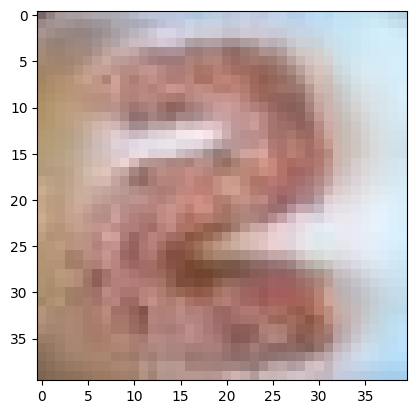

torch.Size([3, 40, 40])


In [6]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(img.shape)

imshow(train_dataset[2][0])


In [7]:
# for data, target in train_loader:
#     print(data)
#     print(target)
#     break

In [8]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in loader:

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)  # use this loss for any training statistics
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch + 1}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model.state_dict(), "weights.pth")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [9]:
# net = resnet18(num_classes=200)

# net.maxpool = nn.ReLU()
# net.conv1.stride = (1, 1)
# net.layer2[0].conv1.stride = (1, 1)
# net.layer2[0].downsample[0].stride = (1, 1)

# net.layer3[0].conv2.stride = (1, 1)
# net.layer3[0].downsample[0].stride = (1, 1)

# net.layer4[0].conv2.stride = (1, 1)
# net.layer4[0].downsample[0].stride = (1, 1)

# print(net)

In [18]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)

print(net)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
# net = efficientnet_v2_s(num_classes=200)

# net(torch.zeros((64, 3, 40, 40), dtype=torch.float).to(device)).shape

In [12]:
net = net.to(device)

In [13]:
torch.manual_seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader)

100%|██████████| 1250/1250 [04:23<00:00,  4.75it/s]


Epoch 1
 train loss: 5.104559898376465, train acc: 0.020099999383091927
 val loss: 4.727747917175293, val acc: 0.04702476039528847



100%|██████████| 1250/1250 [04:16<00:00,  4.87it/s]


Epoch 2
 train loss: 4.564581871032715, train acc: 0.06481249630451202
 val loss: 4.281100749969482, val acc: 0.09784345328807831



100%|██████████| 1250/1250 [04:14<00:00,  4.90it/s]


Epoch 3
 train loss: 4.106446266174316, train acc: 0.11869999766349792
 val loss: 3.797623872756958, val acc: 0.159944087266922



100%|██████████| 1250/1250 [04:20<00:00,  4.80it/s]


Epoch 4
 train loss: 3.688138008117676, train acc: 0.1780499964952469
 val loss: 3.437154531478882, val acc: 0.21865016222000122



100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s]


Epoch 5
 train loss: 3.391072988510132, train acc: 0.227524995803833
 val loss: 3.2741031646728516, val acc: 0.24780350923538208



100%|██████████| 1250/1250 [04:43<00:00,  4.42it/s]


Epoch 6
 train loss: 3.1594533920288086, train acc: 0.26678749918937683
 val loss: 3.0533409118652344, val acc: 0.2889876067638397



100%|██████████| 1250/1250 [04:54<00:00,  4.25it/s]


Epoch 7
 train loss: 2.9674556255340576, train acc: 0.3034000098705292
 val loss: 2.965693473815918, val acc: 0.30950480699539185



100%|██████████| 1250/1250 [04:26<00:00,  4.69it/s]


Epoch 8
 train loss: 2.796008825302124, train acc: 0.33611249923706055
 val loss: 2.836110830307007, val acc: 0.337210476398468



100%|██████████| 1250/1250 [04:21<00:00,  4.78it/s]


Epoch 9
 train loss: 2.6554622650146484, train acc: 0.3627375066280365
 val loss: 2.7940144538879395, val acc: 0.3473941683769226



100%|██████████| 1250/1250 [04:20<00:00,  4.80it/s]


Epoch 10
 train loss: 2.5263397693634033, train acc: 0.3887749910354614
 val loss: 2.7020864486694336, val acc: 0.3648163080215454



In [23]:
# net.load_state_dict(torch.load(
#     "weights.pth",
#     map_location=lambda storage, loc: storage.cuda(0),
#     weights_only=True,
# ))
# net = net.to(device)

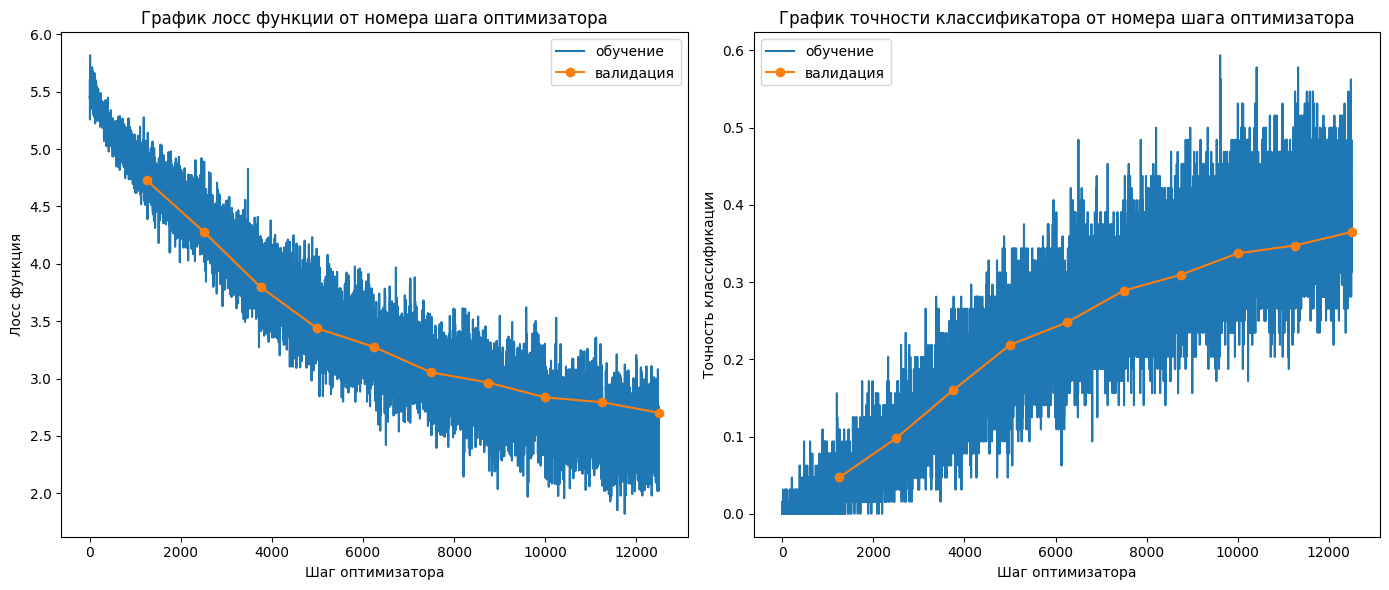

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация", marker = "o")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация", marker = "o")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].legend()
plt.tight_layout()
plt.show()

In [24]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        transform = v2.Normalize((128, 128, 128), (128, 128, 128))
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
        img = transform(img).unsqueeze(0)
        logits = net(img)[0]
        pred.append(int(logits.argmax().to("cpu")))


100%|██████████| 10000/10000 [04:22<00:00, 38.04it/s]


In [25]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [26]:
df.to_csv("labels_test.csv", index=False)